Circuit Summary:

Results (Target state was 1): {'000': 1000}


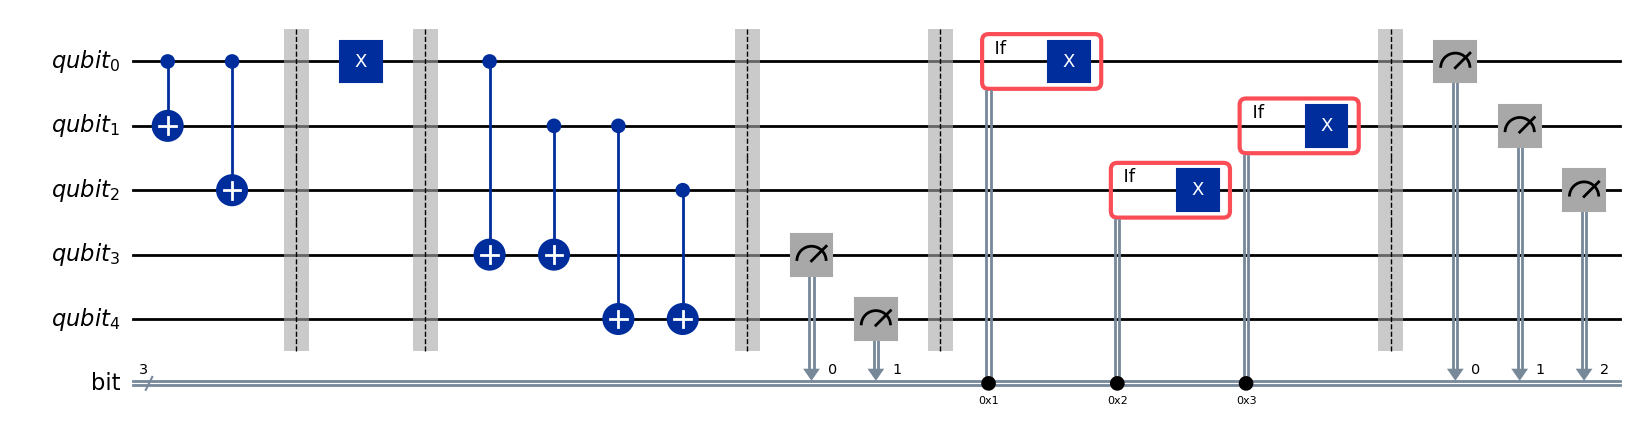

In [13]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import circuit_drawer

# N = 2n + 1
N = 3
# Important functions
def gray_to_binary(g: int) -> int:
    x = g
    while g:
        g >>= 1
        x ^= g
    return x

def to_n_bits(x: int, n: int) -> int:
    return x & ((1 << n) - 1)

def majority_bit(x: int, n: int) -> int:
    return x.bit_count() > n // 2

# 1. Setup Registers
# We use 3 qubits for the code, 2 ancilla qubits, 2 ancilla classical bits, and 2 + 1 classical bit for the result
q = QuantumRegister(2*N - 1, 'qubit')
c = ClassicalRegister(N, 'bit')
qc = QuantumCircuit(q, c)

# You can also play with the following
# qc.x(q[0]) sets initial state to |1>
# qc.h(q[0]) sets initial state to (|0> + |1>) / sqrt(2)

# --- STEP 1: ENCODING ---
# Spread the state to qubit 1 and 2 (Encoding |1> into |111>)
for i in range(1, N):
    qc.cx(q[0], q[i])
qc.barrier()

# --- STEP 2: INTRODUCE ERROR ---
# We simulate an error by flipping qubit 1. 
# You can change this to q[0] or q[2] and the code will still work!
for i in range(N//2):
    qc.x(q[i])
qc.barrier()

# --- STEP 3: DETECTION & CORRECTION ---
# Heart of the correction code
for i in range(N - 1):
    qc.cx(q[i], q[i + N])
    qc.cx(q[i + 1], q[i + N])
qc.barrier()

for i in range(N - 1):
    qc.measure(q[i + N], c[i])
qc.barrier()

for i in range(1, 2 ** (N - 1)):
    with qc.if_test((c, i)):
        num = to_n_bits(gray_to_binary(i), N)
        if(majority_bit(num, N) == 1):
            num = ~num
        for j in range(N):
            if(num % 2 == 1):
                qc.x(q[j])
            num >>= 1
qc.barrier()

# I'm not sure if we really need this because Gemini did this
# The Toffoli gate (CCX) flips qubit 0 back if BOTH q1 and q2 are 1.
# This effectively performs a "majority vote" correction.
# qc.ccx(q[2], q[1], q[0])
# qc.barrier()

# --- STEP 4: MEASUREMENT ---
# We measure the corrected logical qubits
for i in range(N):
    qc.measure(q[i], c[i])

# --- EXECUTION ---
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
job = simulator.run(compiled_circuit, shots=1000)
result = job.result()
counts = result.get_counts()

print("Circuit Summary:")
# print(qc.draw(output='text'))
print(f"\nResults (Target state was 1): {counts}")
qc.draw("mpl")